# Aufgabe 2.11 - 2D-Wellengleichung
Auch wenn wir diese Aufgabe recht einfach ohne Lösung eines Gleichungssystems lösen können, können wir auch die Ergebnisse der letzten drei Tage zu einem allgemeinen Finite-Differenzen-Solver zusammenfassen.

In [389]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.lines as mlines
import numpy as np
from matplotlib import cm
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
np.set_printoptions(linewidth=200)

Zunächst definieren wir eine allgemeine Klasse Mesh, sowie ein äquidistantes (1D/2D) und ein äquidistantes periodisches (1D/2D) Mesh. Sie unterscheiden sich dadurch, was als Nachbar zurückgegeben wird.

Für den Knoten $(0,0)$ gibt das periodische Mesh den Süd-Nachbar $(0, n_y - 1)$ und den West-Nachbar $(n_x \cdot n_y - 1, 0)$ zurück.

In [2]:
class Mesh():
    def getNESW(self, pos):
        return [self.getNorth(pos), self.getEast(pos), self.getSouth(pos), self.getEast(pos)]
    def isBorderPoint(self, pos):
        return not(self.hasNorth(pos) and self.hasEast(pos) and self.hasSouth() and self.hasWest())
    def pointType(self, pos):
        horizontalType = - int(not(self.hasWest(pos))) + int(not(self.hasEast(pos)))
        verticalType = - int(not(self.hasSouth(pos))) + int(not(self.hasNorth(pos)))
        return [horizontalType, verticalType]

In [3]:
class equidistant2DMesh(Mesh):
    def __init__(self, L, H, n_x, n_y):
        self.mesh = []
        self.nNodes = n_x * n_y
        self.n_x = n_x
        self.n_y = n_y
        self.L = L
        self.H = H
        self.delta_x = L / (n_x - 1)
        self.delta_y = H / (n_y - 1)
        for i in np.linspace(0, L, n_x):
            for j in np.linspace(0, H, n_y):
                self.mesh += [[i, j]]
    def getNorth(self, pos, n=1):
        return self.getSouth(pos, n=-n)
    def getSouth(self, pos, n=1):
        return pos - n
    def getWest(self, pos, n=1):
        return pos - self.n_y * n
    def getEast(self, pos, n=1):
        return self.getWest(pos, n=-n)
    def hasNorth(self, pos, n=1):
        return (pos + n) < (int(pos / self.n_y) + 1) * self.n_y
    def hasSouth(self, pos, n=1):
        return (pos - n) >= (int(pos / self.n_y)) * self.n_y
    def hasEast(self, pos, n=1):
        return pos < self.nNodes - n * self.n_y
    def hasWest(self, pos, n=1):
        return pos >= self.n_y * n
    def index_to_i_j(self, index):
        n_x = int(index/self.n_y)
        n_y = index % self.n_y
        return [n_x, n_y]
    def i_j_to_index(self, i, j):
        return i * self.n_y + j
class periodic2DMesh(Mesh):
    def __init__(self, L, H, n_x, n_y):
        self.mesh = []
        self.nNodes = n_x * n_y
        self.n_x = n_x
        self.n_y = n_y
        self.L = L
        self.H = H
        self.delta_x = L / (n_x - 1)
        self.delta_y = L / (n_y - 1)
        for i in np.linspace(0, L, n_x+1)[0:-1]:
            for j in np.linspace(0, H, n_y+1)[0:-1]:
                self.mesh += [[i, j]]
    def getNorth(self, pos, n=1):
        return self.getSouth(pos, n=-n)
    def getSouth(self, pos, n=1):
        return (pos - n) % self.n_y + int(pos / self.n_y) * self.n_y
    def getWest(self, pos, n=1):
        return (pos - self.n_y * n) % (self.n_y * self.n_x)
    def getEast(self, pos, n=1):
        return self.getWest(pos, n=-n)
    def hasNorth(self, pos, n=1):
        return True
    def hasSouth(self, pos, n=1):
        return True
    def hasEast(self, pos, n=1):
        return True
    def hasWest(self, pos, n=1):
        return True
    def index_to_i_j(self, index):
        n_x = int(index/self.n_y)
        n_y = index % self.n_y
        return [n_x, n_y]
    def i_j_to_index(self, i, j):
        return i * self.n_y + j

### Aufgabe 2.11.1 / 2.11.2

Die Hauptklasse __Solver__:

Das Gleichungsssytem wird in der Form $$e_1 \frac{\partial u}{\partial t} + e_2\frac{\partial^2 u}{\partial t^2} = e_3 \frac{\partial u}{\partial x} + e_4 \frac{\partial^2 u}{\partial x^2} + e_5 \frac{\partial u}{\partial y} + e_6 \frac{\partial^2 u}{\partial y^2}$$ erwartet.

Kürzen wir die (diskretisierte) rechte Seite zunächst mit $R_{i}$ ab, erhalten wir für das Crank-Nicholson-Verfahren bei Rückwärtsintegration in der Zeit:

$$\frac{e_2}{\Delta t^2}\begin{pmatrix}1 & -2 & 1\end{pmatrix} \begin{pmatrix}u_{i}^{n-1} \\ u_{i}^{n} \\ u_{i}^{n+1}\end{pmatrix} +
\frac{e_1}{\Delta t}\begin{pmatrix}0 & -1 & 1\end{pmatrix} \begin{pmatrix}u_{i}^{n-1} \\ u_{i}^{n} \\ u_{i}^{n+1} \end{pmatrix}  = \alpha R_{i}^{n+1} + (1 - \alpha) R_{i}^n$$

Wir multiplizieren mit $\Delta t$ durch und schreiben alle alten Terme auf die rechte, alle neuen Terme auf die linke Seite:

$$ \left(e_2 + \Delta t e_1\right) u_{i}^{n+1} - \Delta t^2 \alpha R_{i}^{n+1} =  \left(\Delta t e_1  + 2e_2\right)u_{i}^{n} + \Delta t^2 (1 - \alpha) R_{i}^n - e_2u_{i}^{n-1} $$

Nun sei $R_i^n = \mathbf R \vec u^n$, und wir können in Matrixnotation schreiben:

$$ \left(\left(e_2 + \Delta t e_1\right)\mathbf I - \alpha\Delta t^2 \mathbf R \right) \vec u^{n+1}= \left( \left(\Delta t e_1 + 2e_2\right)\mathbf I + \Delta t^2 (1 - \alpha) \mathbf R\right) \vec u^n - e_2 \mathbf I \vec u^{n-1} $$

Das können wir auch als $ \mathbf A \vec u^{n+1}= \mathbf B \vec u^n + \mathbf C \vec u^{n-1} $ schreiben, mit:
$$\mathbf A = \left(e_2 + \Delta t e_1\right)\mathbf I - \alpha\Delta t^2 \mathbf R $$ $$ \mathbf B = \left(\Delta t e_1 + 2e_2\right)\mathbf I + \Delta t^2 (1 - \alpha) \mathbf R $$ $$ \mathbf C = - e_2 \mathbf I$$

In jedem Schritt wird nun zunächst die rechte Seite $\vec r^{n+1} = \mathbf B \vec u^n + \mathbf C \vec u^{n-1} $ berechnet, und auf das Gleichungsssytem $ \mathbf A \vec u^{n+1}= \vec r^{n+1}$ die Randbedingungen angewendet. Dieses wird dann gelöst.

Wenn keine Anfangsbedingungen vorgegeben wird, ist $\mathbf A = \mathbf R, \mathbf B = \mathbf C = 0$ und das System wird stationär gelöst.

In [369]:
class solver():
    def __init__(self, mesh, equation, time_discretisation, space_discretisations, boundaries):
        self.mesh = mesh
        self.equation = equation
        self.time_discretisation = time_discretisation
        self.space_discretisation = space_discretisations
        self.boundaries = boundaries
    def assemble(self):
        self.R = np.zeros((mesh.nNodes, mesh.nNodes))
        for d in range(len(self.space_discretisation)):
            currentR = self.space_discretisation[d].coefficientsR(mesh)
            self.R += currentR[0] * self.equation[2 + d * 2] + currentR[1] * self.equation[2 + d * 2 + 1] 
        self.A, self.B, self.C = self.time_discretisation.coefficientsABC(self.R, self.equation[0], self.equation[1])
    def applyBC(self, matrix, rhs):
        for bc in self.boundaries:
            bc.apply(self.mesh, matrix, rhs)
    def solve(self, timesteps, initial_conditions):
        solution = np.zeros((timesteps + len(initial_conditions), self.mesh.nNodes))
        inits = len(initial_conditions)
        if (inits == 0 and (timesteps == 0 or (self.equation[0] == 0 and self.equation[1] == 0))): # stationär lösen
            rhs = np.zeros((mesh.nNodes))
            self.applyBC(self.R, rhs)
            solution = np.linalg.solve(self.R, rhs)
        elif (inits == 1 and self.equation[2] != 0):
            raise ValueError("Anfangsbedingung fehlt")
        else:
            solution[0:inits,:] = initial_conditions
            for i in range(inits, timesteps + inits):
                rhs = np.matmul(self.B, solution[i-1])
                if (inits == 2):
                    rhs += np.matmul(self.C, solution[i-2]) 
                self.applyBC(self.A, rhs)
                solution[i] = np.linalg.solve(self.A, rhs)
        return solution

__Zeitliche Diskretisierung__

Dem Solver wird ein Objekt übergeben, das die Informationen über die zeitliche Diskretisierung enthält. Derzeit: Crank-Nicholson-Verfahren, Euler Explizit, Euler Implizit. 

In [370]:
class crank_nicholson():
    def __init__(self, delta_t, alpha=0.5):
        self.alpha = alpha
        self.delta_t = delta_t
    def coefficientsABC(self, R, e_1, e_2):
        return [np.eye(len(R)) * (e_2 + self.delta_t * e_1) - self.delta_t**2 * self.alpha * R, 
                + R * (1 - self.alpha) * self.delta_t**2 + np.eye(len(R)) * (2 * e_2 + self.delta_t * e_1), - np.eye(len(R)) * e_2]
class Euler_explizit(crank_nicholson):
    def __init__(self, delta_t):
        super(Euler_explizit,self).__init__(delta_t, alpha=0)
class Euler_implizit(crank_nicholson):
    def __init__(self, delta_t):
        super(Euler_implizit,self).__init__(delta_t, alpha=1)

__Räumliche Diskretisierung__

Auch die räumliche Diskretisierung ist frei wählbar (Zentraldifferenz oder Upwind). Der Trick dabei ist, dass sich die drei Verfahren nur duch die Koeffizienten für (W, P, O) bzw. (S, P, N) unterscheiden, aber ansonsten identisch funktionieren.

In [371]:
class RaeumlicheDiskretisierung():
    def __init__(self, horizontal, delta_x):
        self.horizontal = horizontal
        self.delta_x = delta_x
        self.coefficients_second = np.array((1, -2, 1)) / delta_x **2
    def coefficientsR(self, mesh):
        coef_first = np.zeros((mesh.nNodes, mesh.nNodes))
        coef_second = np.zeros((mesh.nNodes, mesh.nNodes))
        for i in range(mesh.nNodes):
            if (self.fill(mesh, i, coef_first, coef_second)):
                coef_first[i,:] = 0
                coef_second[i,:] = 0
        return [coef_first, coef_second]     
    def fill(self, mesh, i, coef_first, coef_second = None):
        deleteRow = False
        for j in range(len(self.coefficients)):
            idx = -1
            if (self.start_index + j < 0): # West / Süd
                if (self.horizontal and mesh.hasWest(i, n=-self.start_index -j)):
                    idx = mesh.getWest(i, n=-self.start_index-j)

                elif (not(self.horizontal) and mesh.hasSouth(i, n=-self.start_index-j)):
                    idx = mesh.getSouth(i, n=-self.start_index-j)
            elif (self.start_index + j == 0): # pos
                idx = i
            else:
                if (self.horizontal and mesh.hasEast(i, n=self.start_index +j)):
                    idx = mesh.getEast(i, n=self.start_index+j)
                elif (not(self.horizontal) and mesh.hasNorth(i, n=self.start_index+j)):
                    idx = mesh.getNorth(i, n=self.start_index+j)
            if (idx != -1):
                coef_first[i, idx] += self.coefficients[j] 
                if not(coef_second is None):
                    coef_second[i, idx] += self.coefficients_second[j] 
            else:
                deleteRow = True
        return deleteRow
class Zentraldifferenz(RaeumlicheDiskretisierung):
    def __init__(self, horizontal, delta_x):
        super(Zentraldifferenz,self).__init__(horizontal, delta_x)
        self.coefficients = np.array((1, 0, -1)) / delta_x / 2
        self.start_index = -1
class Upwind(RaeumlicheDiskretisierung):
    def __init__(self, horizontal, delta_x, U):
        super(Upwind,self).__init__(horizontal, delta_x)
        self.coefficients = np.array((-max(0, U), max(0, U) - min(0, U), min(0, U))) / delta_x / U
        self.start_index = -1

### Aufgabe 2.11.3
__Randbedingungen__

Es können Neumann- und Dirichlet-Randbedingungen an beliebigen Stellen im Netz vorgegeben werden:
* Dirichlet-Randbedingungen schreiben direkt in die Matrix.
* Neumann-Randbedingungen wählen je nach Richtung und Position ein passendes Diskretisierungsverfahren aus und benutzen dessen `fill`-Methode.

Ebenfalls können Randbedingungen vorgegeben werden (Neumann oder Dirichlet), die auf alle Netzpunkte entlang einer Linie angewendet werden.

In [379]:
class rb():
    def __init__(self, position):
        self.position = position
class neumann(rb):
    def __init__(self, position, fluss, vertikal):
        super(neumann,self).__init__(position)
        self.fluss = fluss # als Vektor
        self.vertikal = vertikal
    def apply(self, mesh, systemmatrix, rhs):
        if (self.position < 0 or self.position > mesh.nNodes -1 ):
            raise ValueError("Out of bounds")
        delta = mesh.delta_y if self.vertikal else mesh.delta_x
        verfahren = [Upwind(not(self.vertikal), delta, -1), Zentraldifferenz(not(self.vertikal), delta), Upwind(not(self.vertikal), delta, 1)]
        typ = mesh.pointType(self.position)
        gew_verfahren = verfahren[typ[1] + 1] if self.vertikal else verfahren[typ[0] + 1]
        systemmatrix[self.position] = 0
        gew_verfahren.fill(mesh, self.position, systemmatrix)
        rhs[self.position] = self.fluss
class dirichlet(rb):
    def __init__(self, position, stromfunktion):
        super(dirichlet,self).__init__(position)
        self.stromfunktion = stromfunktion
    def apply(self, mesh, systemmatrix, rhs):
        if (self.position < 0 or self.position > mesh.nNodes -1 ):
            raise ValueError("Out of bounds")
        systemmatrix[self.position] = 0
        systemmatrix[self.position, self.position] = 1
        rhs[self.position] = self.stromfunktion
def dist_finite(x1, y1, x2, y2, x3, y3): # x3,y3 is the point
    px = x2-x1
    py = y2-y1
    norm = px*px + py*py
    u =  ((x3 - x1) * px + (y3 - y1) * py) / float(norm)
    if u > 1:
        u = 1
    elif u < 0:
        u = 0
    x = x1 + u * px
    y = y1 + u * py
    dx = x - x3
    dy = y - y3
    dist = (dx*dx + dy*dy)
    return dist
class line():
    def __init__(self, position_x, position_y, prototyp):
        self.start_x = position_x[0]
        self.end_x = position_x[1]
        self.start_y = position_y[0]
        self.end_y = position_y[1]
        self.prototyp = prototyp
    def apply(self, mesh, systemmatrix, rhs):
        rben = []
        for i in range(mesh.nNodes):
            point=mesh.mesh[i]
            dist = dist_finite(self.start_x, self.start_y, self.end_x, self.end_y, point[0], point[1])
            if dist < 0.001:
                self.prototyp.position = i
                #print("Located Point on BC: indices ({}, {})".format(randb.position_x, randb.position_y))
                self.prototyp.apply(mesh, systemmatrix, rhs)

Aufgabe 2.3.4

In [380]:
L = 10
H = 10
n_x = 41
n_y = 41
c = 1
delta_t = 0.1
mesh = equidistant2DMesh(L, H, n_x, n_y) 
boundaries = [line((0, 0), (0, H), dirichlet(0, 0)), 
                    line((L, L), (0, H), dirichlet(0, 0)), 
                    line((0, L), (0, 0), dirichlet(0, 0)), 
                    line((0, L), (H, H), dirichlet(0, 0))]
s = solver(mesh, [0, 1, 0, c**2, 0, c**2], Euler_implizit(delta_t), [Zentraldifferenz(True, mesh.delta_x), Zentraldifferenz(False, mesh.delta_y)], boundaries)
#s = solver(periodic2DMesh(L, H, n_x, n_y), [0, 1, 0, c**2, 0, c**2], crank_nicholson(delta_t), [Zentraldifferenz(True, mesh.delta_x), Zentraldifferenz(False, mesh.delta_y)], [])
ab1 = np.zeros([mesh.nNodes])
ab2 = np.zeros([mesh.nNodes])
ab2[mesh.i_j_to_index(int((n_x -1) / 2), int((n_y - 1) / 2))] = 1

In [386]:
s.assemble()
result = s.solve(100, [ab1, ab2])

In [437]:
def plot(step=0): 
    plt.figure(figsize=(7.5,6))
    plot_internal(step)
    plt.show()
def plot_internal(step=0):
    plt.title("Wellengleichung, t={}".format(step*delta_t))
    plt.xlabel("x-Koordinate")
    plt.ylabel("y-Koordinate")
    plt.contourf(np.linspace(0, L, n_x), np.linspace(0, H, n_y), result[step].reshape((n_y, n_x), order='F'), 50)
    plt.colorbar()
interact(plot, step=widgets.IntSlider(min=0, max=100, step=1, value=0))

interactive(children=(IntSlider(value=0, description='step'), Output()), _dom_classes=('widget-interact',))

<function __main__.plot(step=0)>

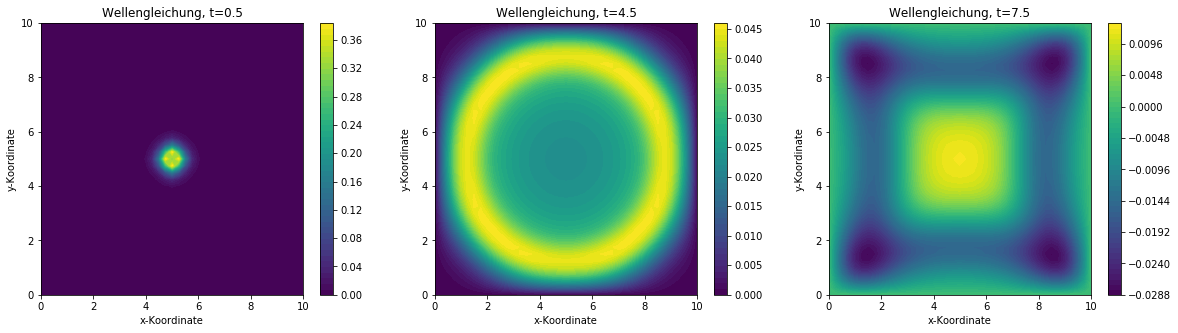

In [439]:
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plot_internal(5)
plt.subplot(1, 3, 2)
plot_internal(45)
plt.subplot(1, 3, 3)
plot_internal(75)
plt.show()